# Example : DIPSHIFT

In [1]:
# git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

## Build the spin system
For relaxation induced by exchange, we always build the spin system with at least two different sets of interactions. Not all interactions must change, but at least one interaction should be different– otherwise no relaxation will occure. Note that best-practice is to build the first spin-system, and copy it and only edit the parameters that are changed in the second spin-system.

pyRelaxSim takes the main experimental parameters (excepting rf fields) upon initialization of a spin-system, and then interactions are added afterwards.

In [33]:
ex0=RS.ExpSys(v0H=600,vr=5000,Nucs=['13C','1H'],pwdavg=RS.PowderAvg(q=3))     #1-spin system at 600 MHz (14.1 T)
delta=RS.Tools.dipole_coupling(.109,'1H','13C')       #Built-in dipole coupling calculator
ex0.set_inter(Type='dipole',i0=0,i1=1,delta=delta)    #Dipole coupling
ex1=ex0.copy()   #Copies the spin system
ex1.set_inter(Type='dipole',i0=0,i1=1,delta=delta,euler=[0,60*np.pi/180,0])   #60 degree hop of dipole coupling

## Define Liouvillian, pulse sequence, initial density operator, detection operator

In [63]:
L=RS.Liouvillian((ex0))  #Liovillian with both Hamiltonians
seq_homo=RS.Sequence(L)
seq_het=RS.Sequence(L)
seq_ref=RS.Sequence(L)
v1=65000
voff=v1/np.tan(np.arccos(np.sqrt(1/3)))
v1pi=62500
tpi=1/v1pi/2
seq_homo.add_channel('1H',v1=v1,voff=voff,t=[0,L.taur-tpi/2])   #Pulse sequence during homonuclear decoupling
seq_het.add_channel('1H',v1=v1,t=[0,L.taur-tpi/2])  #Pulse sequence during heteronuclear decoupling
seq_ref.add_channel('1H',v1=v1,t=[0,L.taur+tpi/2])  #Pulse sequence during refocusing
seq_ref.add_channel('13C',v1=[v1pi,0,0],t=[0,tpi,tpi/2+L.taur])

## Prepare propagators for different parts of the rotor period
Rotor period broken into npts

In [74]:
npts=17
Dt=(L.taur-tpi/2)/(npts-1)

L.reset_prop_time()
Uhet=list()
for _ in range(npts-1):
    Uhet.append(seq_het.U(Dt=Dt))
L.reset_prop_time()
Uhomo=list()
for _ in range(npts-1):
    Uhomo.append(seq_homo.U(Dt=Dt))
Uref=seq_ref.U()

## Execute the sequence
First prepare the initial density operator and detection operator. Then loop over the time points

Text(0.5, 0, '$t$ / $\\mu$s')

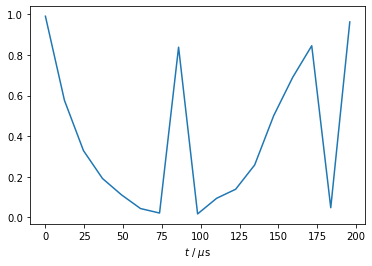

In [82]:
rho=RS.Rho(rho0='13Cx',detect='13Cx',L=L)
for k in range(npts):
    rho.reset()
    for m in range(k):
        Uhomo[m]*rho
    for m in range(k,npts-1):
        Uhet[m]*rho
    Uref*rho
    rho()
ax=plt.figure().add_subplot(111)
ax.plot(np.arange(npts)*Dt*1e6,rho.I[0].real)
ax.set_xlabel(r'$t$ / $\mu$s')

In [81]:
rho.t

0.00020825000000000002

In [62]:
rho.taur

0.0002

In [64]:
(np.prod(Uhomo)).Dt

AttributeError: 'numpy.complex64' object has no attribute 'Dt'

In [65]:
U1=np.prod(Uhomo)

In [66]:
U1

0j

In [71]:
L.reset_prop_time()
U1=L.Ueye()
for U0 in Uhomo:
    U1=U0*U1

In [72]:
U1.Dt

0.00020825000000000002

In [73]:
U1.taur

0.0002